<a href="https://colab.research.google.com/github/GalaxyTab7/Data219_0-Gang_Final/blob/main/Data219_ML_Conclusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML Intro

With the analysis complete, we can now begin testing models, parameters, and hyperparameters until we find a model that predicts the 2023 'DF' score with the lowest absolute mean error.

The factors used during the testing/tuning process:
- 2022 'DF' score
- age
- years playing
- bio
- win rate
- total series/fights using top character
- global ranking in 2022
- matches
- most played character

The models to be tested/tuned:
- KNN regressor
- Bayesian ridge regressor
- Linear regressor
- Decesion Tree regressor

Unfortunately, only 243 points in the dataset have a valid 2023 df score. Consequently, these 243 points will be used for testing/tuning.

# Dependencies and Imports

In [ ]:
#Dependicies/Imports
import pandas as pd
import numpy as np
import plotly.express as px
import scipy.stats as stats
import re
import itertools
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import BayesianRidge
pd.options.mode.chained_assignment = None

# Loading In Data

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/GalaxyTab7/Data219FinalProject/main/Cleaned_Data" , encoding = 'utf-8')
data_with_df = pd.read_csv("https://raw.githubusercontent.com/GalaxyTab7/Data219FinalProject/main/Cleaned_Training_Data" , encoding = 'utf-8')

# Identifying Models and Parameters

First, we are going to transform the data by standardizing the quantitative features, dummy-encoding the 'top_character' feature, and using a TFIDF vec on the 'bio' feature.

In [ ]:
#Transform the data
scaler = StandardScaler()
dummy = OneHotEncoder()
TFIDF = TfidfVectorizer()

num = scaler.fit_transform(data_with_df[['DF_2022','age','years_playing','win_rate','Global_2022','num_games_with_top_char']])
encod = dummy.fit_transform(data_with_df[['top_character']])
vec = TFIDF.fit_transform(data_with_df[['bio']])


numDf = pd.DataFrame(num , columns = scaler.get_feature_names_out())
encodDf = pd.DataFrame(encod.todense() , columns = dummy.get_feature_names_out())
vecDf = pd.DataFrame(vec.todense() , columns = TFIDF.get_feature_names_out())

list_topChar = [value for value in dummy.get_feature_names_out()]
list_bio = [value for value in TFIDF.get_feature_names_out()]

clean_df = pd.concat((numDf,encodDf,vecDf) , axis = 1)
clean_df['Df_2023'] = data_with_df['Df_2023'].values
clean_df = clean_df.fillna(0)

Now, we are going to find which combination of features leads to the lowest absolute mean error for each of the models to be tested. This will also help to identify which model is best to use.

In [ ]:
#This code gets all possible combinations of all possible sizes from the list of factors
list_features = ['DF_2022','age','years_playing','win_rate','Global_2022','num_games_with_top_char','has_bio','has_top_char']

dict_result = {}
for n in range(1,len(list_features)):
  result = [value for value in itertools.combinations(list_features , n)]
  dict_result[n] = result

#This loop finds the cross val score for all the combinations of all possible sizes
#from the list of factors for each model being tested.
dict_results = {}
for row,list_combinations in dict_result.items():
  for (col_combo) in  list_combinations:
    list_add = []
    list_argue = []
    list_key = []
    for col in col_combo:
      if col == 'has_bio':
        list_key.append('bio')
        for value in list_bio:
          list_argue.append(value)
      elif col == 'has_top_char':
        list_key.append('top_character')
        for value in list_topChar:
          list_argue.append(value)
      else:
        list_key.append(col)
        list_argue.append(col)

    print(list_key)

    #Set x and y
    x = clean_df[list_argue]
    y = clean_df['Df_2023']

    #Initialize the sckitlearn stuff
    Knn = KNeighborsRegressor()
    Bae = BayesianRidge()
    Lin = LinearRegression()
    Monke = DecisionTreeRegressor()

    #Get cross val scores
    knn_score = cross_val_score(Knn, X=x , y=y , cv = 10 , scoring = 'neg_mean_absolute_error')
    bae_score = cross_val_score(Bae, X=x, y=y , cv = 10 , scoring = 'neg_mean_absolute_error' )
    lin_score = cross_val_score(Lin, X=x , y=y , cv = 10 , scoring = 'neg_mean_absolute_error')
    monke_score = cross_val_score(Monke, X=x , y=y , cv = 10 , scoring = 'neg_mean_absolute_error')

    #Append results
    list_add.append(-knn_score.mean())
    list_add.append(-bae_score.mean())
    list_add.append(-lin_score.mean())
    list_add.append(-monke_score.mean())
    dict_results[str(list_key)] = list_add

#Make result into a dataframe
result = pd.DataFrame.from_dict(dict_results,orient='index',columns=['KNN','BAE','LIN',"MONKE"])
print("All done")

['DF_2022']
['age']
['years_playing']
['win_rate']
['Global_2022']
['num_games_with_top_char']
['bio']
['top_character']
['DF_2022', 'age']
['DF_2022', 'years_playing']
['DF_2022', 'win_rate']
['DF_2022', 'Global_2022']
['DF_2022', 'num_games_with_top_char']
['DF_2022', 'bio']
['DF_2022', 'top_character']
['age', 'years_playing']
['age', 'win_rate']
['age', 'Global_2022']
['age', 'num_games_with_top_char']
['age', 'bio']
['age', 'top_character']
['years_playing', 'win_rate']
['years_playing', 'Global_2022']
['years_playing', 'num_games_with_top_char']
['years_playing', 'bio']
['years_playing', 'top_character']
['win_rate', 'Global_2022']
['win_rate', 'num_games_with_top_char']
['win_rate', 'bio']
['win_rate', 'top_character']
['Global_2022', 'num_games_with_top_char']
['Global_2022', 'bio']
['Global_2022', 'top_character']
['num_games_with_top_char', 'bio']
['num_games_with_top_char', 'top_character']
['bio', 'top_character']
['DF_2022', 'age', 'years_playing']
['DF_2022', 'age', 'win_

KNN
['DF_2022', 'win_rate', 'Global_2022', 'num_games_with_top_char', 'bio', 'top_character'] , 684.465
 
BAE
['DF_2022', 'years_playing', 'bio', 'top_character'] , 698.3266069503826
 
LIN
['DF_2022', 'years_playing', 'num_games_with_top_char'] , 843.8905156922543
 
MONKE
['age', 'years_playing', 'Global_2022', 'num_games_with_top_char', 'top_character'] , 356.91249999999997
 
This graph shows the absolute mean errors for each model, note that the linear model is left out becuase it has such high mean absolute error


<Axes: >

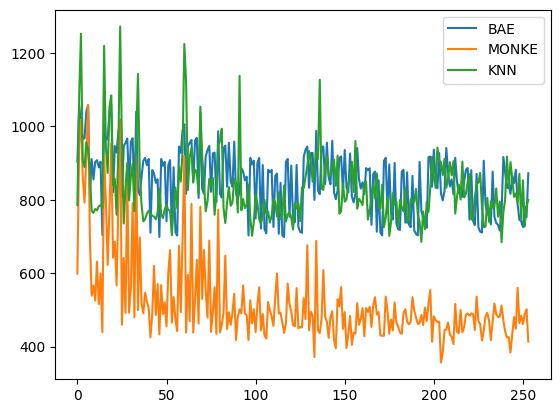

In [ ]:
for col in result.columns:
  print(col)
  print(result[col].idxmin() + " , " + str(result[col].min()))
  print(" ")
print("This graph shows the absolute mean errors for each model, note that the linear model is left out becuase it has such high mean absolute error.")
result[['BAE' , 'MONKE' , 'KNN']].plot(kind='line' , use_index = False)

From the analysis of the parameters, it seems that the best two models are the KNN model and the Decision Tree regression models, For the KNN model, the features used are 'DF_2022', 'win_rate', 'Global_2022', 'num_games_with_top_char', 'bio', and 'top_character'. For the Decision Tree regression model, the features used are 'age', 'Global_2022', 'num_games_with_top_char', 'bio', and 'top_character'. From the graph of the absolute mean errors for each model, it does appear that the Decision Tree regressor performs much better no matter what features are being used. Despite this, the KNN model will still be tuned.

# Hyperparameter Tuning

With the parameters and potential models selected, some of the hyperparameters can be narrowed down.

In [ ]:
#Tuning Hyperparameters for the decesion tree

#Attempt 1
MONKE = DecisionTreeRegressor()
col_transformer = make_column_transformer((StandardScaler(with_mean=False) , ['age' , 'Global_2022' , 'num_games_with_top_char']) , (OneHotEncoder(sparse_output=False,handle_unknown='ignore'),['top_character']) , (TfidfVectorizer(stop_words='english'),'bio'))
MONKE_PIPE = make_pipeline(col_transformer , MONKE)
x = data_with_df[['age' , 'Global_2022' , 'num_games_with_top_char','top_character','bio']]
y = data_with_df[['Df_2023']]
score = cross_val_score(MONKE_PIPE , X=x, y=y,cv=100 , scoring = 'neg_mean_absolute_error')
print("Hyperparameters: with_mean=False | handle_unknown='ignore' | stop_words='english'")
print(-score.mean())

print("\n")

#Attempt 2
MONKE = DecisionTreeRegressor(criterion='friedman_mse')
col_transformer = make_column_transformer((StandardScaler(with_std=False) , ['age' , 'Global_2022' , 'num_games_with_top_char']) , (OneHotEncoder(sparse_output=False,handle_unknown='ignore'),['top_character']) , (TfidfVectorizer(stop_words='english'),'bio'))
MONKE_PIPE = make_pipeline(col_transformer , MONKE)
x = data_with_df[['age' , 'Global_2022' , 'num_games_with_top_char','top_character','bio']]
y = data_with_df[['Df_2023']]
score = cross_val_score(MONKE_PIPE , X=x, y=y,cv=100 , scoring = 'neg_mean_absolute_error')
print("Hyperparameters: criterion='friedman_mse' | with_std=False | handle_unknown='ignore' | stop_words='english'")
print(-score.mean())

print("\n")

#Attempt 3
MONKE = DecisionTreeRegressor(criterion='absolute_error')
col_transformer = make_column_transformer((StandardScaler() , ['age' , 'Global_2022' , 'num_games_with_top_char']) , (OneHotEncoder(sparse_output=False,handle_unknown='ignore'),['top_character']) , (TfidfVectorizer(stop_words='english'),'bio'))
MONKE_PIPE = make_pipeline(col_transformer , MONKE)
x = data_with_df[['age' , 'Global_2022' , 'num_games_with_top_char','top_character','bio']]
y = data_with_df[['Df_2023']]
score = cross_val_score(MONKE_PIPE , X=x, y=y,cv=100 , scoring = 'neg_mean_absolute_error')
print("Hyperparameters: criterion='absolute_error' | handle_unknown='ignore' | stop_words='english'")
print(-score.mean())

print("\n")

#Attempt 4
MONKE = DecisionTreeRegressor(criterion = "poisson")
col_transformer = make_column_transformer((StandardScaler(with_mean=False) , ['age' , 'Global_2022' , 'num_games_with_top_char']) , (OneHotEncoder(sparse_output=False,handle_unknown='ignore'),['top_character']) , (TfidfVectorizer(stop_words='english'),'bio'))
MONKE_PIPE = make_pipeline(col_transformer , MONKE)
x = data_with_df[['age' , 'Global_2022' , 'num_games_with_top_char','top_character','bio']]
y = data_with_df[['Df_2023']]
score = cross_val_score(MONKE_PIPE , X=x, y=y,cv=100 , scoring = 'neg_mean_absolute_error')
print("Hyperparameters: criterion = poisson | with_mean=False | with_std=False | handle_unknown='ignore' | stop_words='english' | ")
print(-score.mean())

Hyperparameters: with_mean=False | handle_unknown='ignore' | stop_words='english'
319.79


Hyperparameters: criterion='friedman_mse' | with_std=False | handle_unknown='ignore' | stop_words='english'
313.18000000000006


Hyperparameters: criterion='absolute_error' | handle_unknown='ignore' | stop_words='english'
422.0366666666667


Hyperparameters: criterion = poisson | with_mean=False | with_std=False | handle_unknown='ignore' | stop_words='english' | 
346.735


Hyperparameters: with_mean=False | handle_unknown='ignore' | stop_words = 'english
1
386.6916666666667


<Axes: >

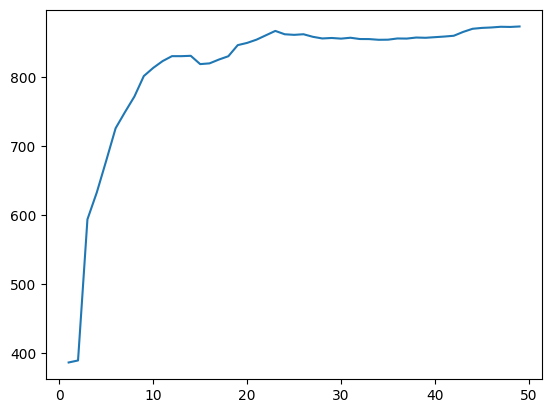

In [ ]:
#Tuning knn

col_transformer = make_column_transformer((StandardScaler(with_mean = False ) , ['Global_2022' , 'DF_2022' , 'win_rate' , 'num_games_with_top_char']) , (OneHotEncoder(sparse_output=False,handle_unknown='ignore'),['top_character']) , (TfidfVectorizer(stop_words='english'),'bio'))
dict_results = {}
for k in range(1,50):
  KNN = Knn = KNeighborsRegressor(n_neighbors =  k)
  KNN_Pipe = make_pipeline(col_transformer , KNN)
  x = data_with_df[['DF_2022', 'win_rate', 'Global_2022', 'num_games_with_top_char', 'bio', 'top_character']]
  y = data_with_df[['Df_2023']]
  score = cross_val_score(KNN_Pipe , X = x , y=y ,cv=10 ,scoring = 'neg_mean_absolute_error')
  dict_results[k] = -score.mean()
print("Hyperparameters: with_mean=False | handle_unknown='ignore' | stop_words = 'english")
result = pd.Series(dict_results)
print(result.idxmin())
print(result.min())
result.plot(kind='line')


After tuning the hyperparameters for both the KNN model and the Decision Tree model, the lowest mean absolute error found is around 300. Considering the small sample size, and the many NaNs in the data, this MAE score is good. Because the Decision Tree model outperformed the KNN model, it will be used as the final model.

# Final Model

Thus, the final model used to predict 2023 'DF' scores is a Decision Tree Regressor model using the features:
- age
- Global_2022
- num_games_with_top_char
- top_character
- bio

The hyperparameters set for this model include:

- criterion='friedman_mse' for the Decision Tree
- with_std=False for the Standard Scaler
- handle_unknown='ignore' for the Dummy Encoder
- stop_words='english' for the TFIDF Vectorizer
With a model selected, a prediction can be made about a player's 'DF' score given the below features. Note that the user could also guestimate some of the values, such as win rate, to utilize the model.
 - age
 - 2022 global ranking
 - number of games with their main character
 - their main character
 - a short description of their achievements/gameplay

The 2022 global ranking may seem like a bit of an odd choice given that the model is supposed to help amateur players understand their ranking in comparison with the pros. However, in the training data, a total of 95 of the points had NaN global 2022 rankings. Those without a global ranking had their values filled with 500. In the actual application of the model, the global 2022 ranking can be set to 500 automatically if the user argues unknown.


# Example Predictions

Below, a simple method is created that predicts the 2023 'DF' scores for all players in the dataset without one. Just after that is an example of how an amateur player could use the model to understand their performance in comparison with the pros. Both of these outputs are simply examples of how the model could be applied in practice.

In [ ]:
#This method makes the prediction
def predict(info):
  MONKE = DecisionTreeRegressor()
  col_transformer = make_column_transformer((StandardScaler(with_mean=False) , ['age' , 'Global_2022' , 'num_games_with_top_char']) , (OneHotEncoder(sparse_output=False,handle_unknown='ignore'),['top_character']) , (TfidfVectorizer(stop_words='english'),'bio'))
  MONKE_PIPE = make_pipeline(col_transformer , MONKE)
  x = data_with_df[['age' , 'Global_2022' , 'num_games_with_top_char','top_character','bio']]
  y = data_with_df[['Df_2023']]
  MONKE_PIPE.fit(x,y)
  return MONKE_PIPE.predict(info)

#This is an example of using the model to predict the 2023 'DF' scores using the players without this score in the dataset.
predict_me_df = data[data['Df_2023'] == 0][['age' , 'Global_2022' , 'num_games_with_top_char','top_character','bio']]
print("Predictions for the unknown 2023 'DF' scores in the model")
print(predict(predict_me_df))


Predictions for the unknown 2023 'DF' scores in the model
[ 390.  325.  325.  780.  325.  102.  325.  780.  150.  325.  150.  780.
  500.  325.  102.  325.  325. 2423. 2423.  325.  325.  878.  390.  234.
  325.  320.  325.  325.  325.  974.  325.  974.  325.  325.  325.  325.
  320. 1093.  325.  325. 2423. 2423. 1217.  325.  325.  195.  390. 2657.
 1093.  325.  325.  325. 1217.  325. 7190.  320.  325.  325.  195. 1093.
 2047. 3811. 2047.  942.  325.  340.   85.  107.   85.  325.  195.  325.
  150.  320.  325.  821.  325.  107.  195.  179. 2423. 1368.  325.  325.
  150.  974.  150. 4000.  234.  390.  325.  179.  234.   85.  320.  320.
  974.  325.  195.  325.  574.  320. 1093.  150.  325.  325.  325.  325.
  340. 2423.  325. 1125. 1093.  942.  390.  325.  325.  325. 2047.   85.
 1093.  390.  974.  390.  500. 1093. 4000. 2423.   85.   85.  649. 1603.
  500.  325.  448.  325. 2423.  170.  195.  500.  150.  500.  500. 1093.
  150.   85.  107.  325.  320.  325.  325.  454. 4000.  325.  390.

In [ ]:
#Example Prediction

#Information about the user
name = "Jeff"
age = 18
last_years_ranking = 500
games_with_favorite_character = 100
top_character = "Ice Climbers"
bio = "I am a new player who has only played in a few tournaments. I won my school smash ultimate tournament, and I beat my friends regularly."

#Making the prediction
predict_me = pd.DataFrame(columns = ['age' , 'Global_2022' , 'num_games_with_top_char','top_character','bio'])
predict_me.loc[name] = [age,last_years_ranking,games_with_favorite_character,top_character,bio]
print("Prediction for Jeff")
print(predict(predict_me)[0])


Prediction for Jeff
325.0


# **Conclusion**

From the analysis portion, we found many relationships between players' attributes and their respective 2023 'DF' scores. For the amateur player seeking to improve their game, the most important relationship we found was that simply playing more with your main character is moderately, and significantly, correlated with a higher 'DF' score. This held true both for winning and losing with the main character. As such, we would recommend that players try to focus on their main and stay dedicated to the challenge, as they will improve no matter win or lose. Further, we found that the difference in mean "DF" scores between groups that have been playing for all but the longest time, here meaning more than ten years, are very similar. As such, we would recommend that players trying to improve not be discouraged by the fear that they are joining the game too late. This is because, as it turns out, there is really only a significant influence on the 'DF' score after at least ten years of play.

From the machine learning portion, we found that the best model to predict the 2023 'DF' score is a Decision Tree Regressor model. This model uses the features, 'age', 'Global_2022', 'num_games_with_top_char', 'top_character', and bio to predict the 2023 'DF' score. After messing with some of the hyperparameters, we were able to get the AME for this model down to around 300. Considering the small sample size, and many NaNs in the data, this error was deemed acceptable. This model can be used by amateur players to guesstimate how they should be ranking, in comparison to other players. Hopefully, such a model will help amateur players set a benchmark for them to beat in future years.

Finally, for future analysis, we would recommend approaching the problem as an unclassified ML issue. Clustering techniques could lead to interesting discoveries on what makes an elite fighting game athlete.